# Maps as subplots

A couple of examples of how to make panel plots of maps. 

Simpler layouts (grid of maps) can use `plt.subplots` while more customized layouts shoud use Matplotlib's `gridspec` library. 

In [2]:
from pathlib import Path  # python's library for dealing with file paths

# I/O and computation
import xarray as xr
import numpy as np
import geocat.comp as gc  # used for interpolation to isobaric levels

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs

# I/O
Load variables the easy way when we know exactly what files and variables are needed. 

(Otherwise, consider intake-esm, but adds some complexity for smaller tasks.)

In [3]:
# Case 1
stem = Path("/Volumes/Drudonna/cam5_1deg_release_amip/atm/proc/tseries/month_1")
ufil = stem / "cam5_1deg_release_amip.cam.h0.U.200101-201012.nc"
vfil = stem / "cam5_1deg_release_amip.cam.h0.V.200101-201012.nc"
psfil = stem / "cam5_1deg_release_amip.cam.h0.PS.200101-201012.nc"

uds = xr.open_dataset(ufil)
vds = xr.open_dataset(vfil)
psds = xr.open_dataset(psfil)


# Case 2 for comparison (combined into a single line)
stem2 = Path("/Volumes/Drudonna/cam4_1deg_release_amip/atm/proc/tseries/month_1")
uds2 =  xr.open_dataset(stem2 / "cam4_1deg_release_amip.cam.h0.U.200011-201012.nc")
vds2 =  xr.open_dataset(stem2 / "cam4_1deg_release_amip.cam.h0.V.200011-201012.nc")
psds2 = xr.open_dataset(stem2 / "cam4_1deg_release_amip.cam.h0.PS.200011-201012.nc")



In [4]:
# get the individual variables out of the datasets.
# -- in some cases, consider merging these into a small dataset to move around together.
u = uds['U']
v = vds['V']
ps = psds['PS']

In [5]:
# Compute the long-term climatology
uclimo = u.mean(dim='time')
vclimo = v.mean(dim='time')
psclimo = ps.mean(dim='time')

# Case 2 -- again in one line
u2climo = uds2['U'].mean(dim='time')
v2climo = vds2['V'].mean(dim='time')
ps2climo = psds2['PS'].mean(dim='time')

In [6]:
#
# convert from hybrid sigma coordinate to single pressure level
#
plev = 200.  # Desired isobaric level in hPa
vplev = gc.interp_hybrid_to_pressure(vclimo, psclimo, uds['hyam'], uds['hybm'], new_levels=np.array([100. * plev]), lev_dim='lev')
vplev = vplev.squeeze(drop=True).load()
uplev = gc.interp_hybrid_to_pressure(uclimo, psclimo, uds['hyam'], uds['hybm'], new_levels=np.array([100. * plev]), lev_dim='lev')
uplev = uplev.squeeze(drop=True).load()

u2plev = gc.interp_hybrid_to_pressure(u2climo, ps2climo, uds2['hyam'], uds2['hybm'], new_levels=np.array([100. * plev]), lev_dim='lev')
v2plev = gc.interp_hybrid_to_pressure(v2climo, ps2climo, vds2['hyam'], vds2['hybm'], new_levels=np.array([100. * plev]), lev_dim='lev')
u2plev = u2plev.squeeze(drop=True).load()
v2plev = v2plev.squeeze(drop=True).load()

# Plots

Demonstrate having several subplots that are all on geographic projections. 

In [7]:

# cartopy doesn't do a good job dealing with longitude 0-360, so switch to -180-180:


def lonFlip(data):
    # NOTE: this assumes global values
    tmplon = data['lon']
    tmpdata = data.roll(lon=len(tmplon) // 2, roll_coords=True)
    lonroll = tmpdata['lon'].values
    if tmplon.min() >= 0:
        # flip to -180:180
        tmpdata = tmpdata.assign_coords({'lon': np.where(lonroll >= 180, lonroll - 360, lonroll)})
    else:
        # flip from -180:180 to 0:360
        tmpdata = tmpdata.assign_coords({'lon': ((lonroll + 360) % 360)})
    return tmpdata



In [8]:
uplev = lonFlip(uplev)
vplev = lonFlip(vplev)
u2plev = lonFlip(u2plev)
v2plev = lonFlip(v2plev)

In [51]:
psclimo = lonFlip(psclimo)
ps2climo = lonFlip(ps2climo)

In [9]:
wspd1 = np.sqrt(uplev**2 + vplev**2)
wspd2 = np.sqrt(u2plev**2 + v2plev**2)

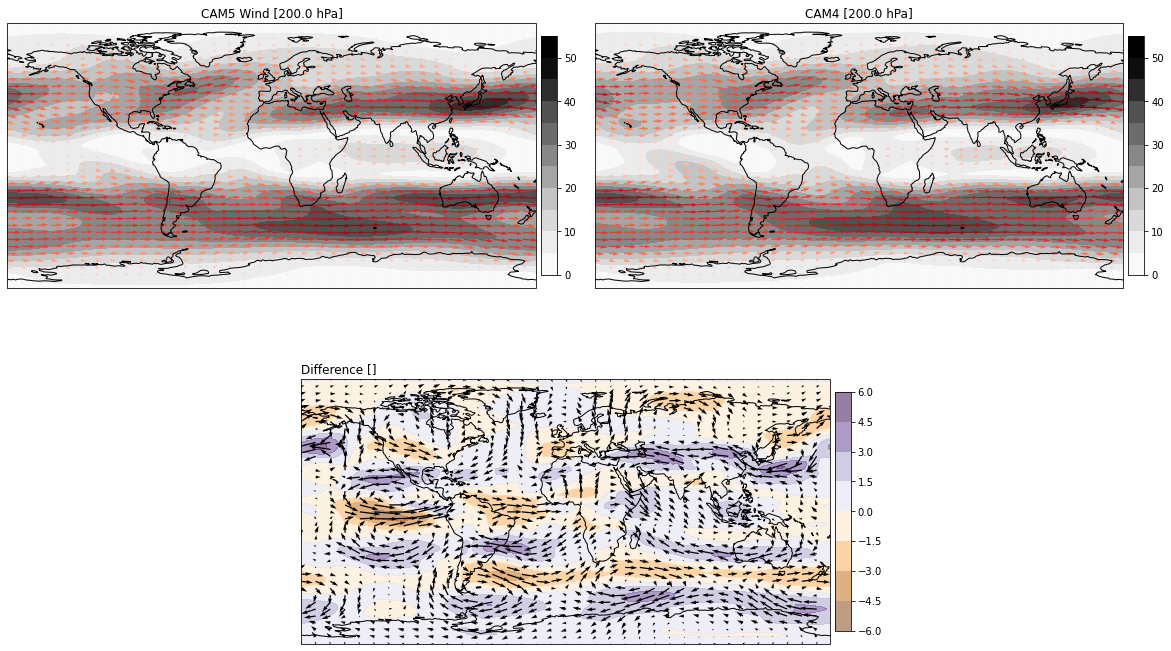

In [66]:
#
# Example 1: vectors over contours on lat-lon map, with difference centered below.
#

# NOTE: this example uses matplotlib's gridspec to control the layout.

proj = ccrs.PlateCarree()

lons, lats = np.meshgrid(uplev['lon'], uplev['lat'])

fig = plt.figure(figsize=(20,12))

# to keep colors the same, use the same color normalization:
color_norm = mpl.colors.Normalize(vmin=0, vmax=50)
color_map = mpl.cm.Greys  # could also just specify string 'Greys'

# to be even more careful specify the contour levels explicitly:
contour_levels = np.linspace(0, 55, 12)

# LAYOUT WITH GRIDSPEC
gs = gridspec.GridSpec(2, 4) # 2 rows, 4 columns, but each map will take up 2 columns
gs.update(wspace=0.25)
ax1 = plt.subplot(gs[0, :2], projection=proj)
ax2 = plt.subplot(gs[0, 2:], projection=proj)
ax3 = plt.subplot(gs[1, 1:3], projection=proj)

# too many vectors to see well, so prune by striding through data:
skip=(slice(None,None,5),slice(None,None,8))


# draw filled contour first, then `quiver` on top.
img1 = ax1.contourf(lons, lats, wspd1, levels=contour_levels, cmap=color_map, norm=color_norm, transform=ccrs.PlateCarree())
qvr1 = ax1.quiver(lons[skip], lats[skip], uplev[skip], vplev[skip], wspd1.values[skip], transform=ccrs.PlateCarree(), cmap='Reds')
ax1.set_title(f"CAM5 Wind [{plev} hPa]")
## Add colorbar to Candidate 1:
# Note: the colorbar is added using matplotlib's `inset_axes` which provides good control over placement.
#       The inset_axes object is attached to the specified Axes object.
cb_c1_ax = inset_axes(ax1,
                   width="3%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0.05, 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0,
                   )
fig.colorbar(img1, cax=cb_c1_ax)

# 2nd plot
img2 = ax2.contourf(lons, lats, wspd2, levels=contour_levels, cmap=color_map, norm=color_norm, transform=ccrs.PlateCarree())
qvr2 = ax2.quiver(lons[skip], lats[skip], u2plev[skip], v2plev[skip], wspd1.values[skip], transform=ccrs.PlateCarree(), cmap='Reds')
ax2.set_title(f"CAM4 [{plev} hPa]")

# could skip this, since the colorbars will be the same;
# Better would be to only have this one, since it will be on the right side.
cb_c2_ax = inset_axes(ax2,
                   width="3%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0.05, 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )
fig.colorbar(img2, cax=cb_c2_ax)

# Difference uses different colors & levels
udif = u2plev - uplev
vdif = v2plev - vplev

img3 = ax3.contourf(lons, lats, wspd1-wspd2, transform=ccrs.PlateCarree(), norm=mpl.colors.TwoSlopeNorm(vmin=-5, vcenter=0.0, vmax=5), cmap='PuOr', alpha=0.5)
qvr2 = ax3.quiver(lons[skip], lats[skip], udif[skip], vdif[skip], transform=ccrs.PlateCarree())

ax3.set_title(f"Difference []", loc='left')
cb_d_ax = inset_axes(ax3,
                   width="3%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0.05, 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0
                   )
fig.colorbar(img3, cax=cb_d_ax)

[a.coastlines() for a in [ax1,ax2,ax3]]

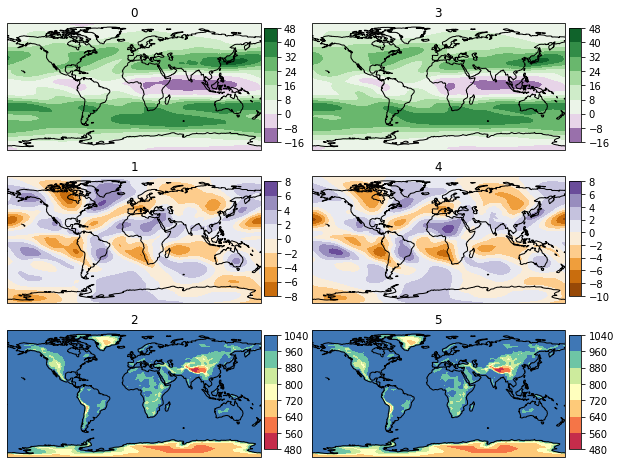

In [68]:
#
# Example 2 - simpler layout just using subplots but with more panels
#

fig2, ax_ex2 = plt.subplots(figsize=(10,8), nrows=3, ncols=2, subplot_kw={"projection":proj})
u_comp_norm = mpl.colors.TwoSlopeNorm(vmin=-20, vcenter=0, vmax=50)
v_comp_norm = mpl.colors.TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10)
# ax_ex2 is an array that holds the axes
# when ax_ex2 is 2-dimensional, either specify the elements by row, column or 
# can loop through by doing for `a in ax_ex2.ravel()`

# this is not the ideal way to tod this, but it works for small one-off scripts:
# make lists for the colorbars and images, and use ravel() keep track of which axes they go to.
colorbars = [] # list of colorbars
img = [] # list of the images used for the colorbars
img.append(ax_ex2[0,0].contourf(lons, lats, uplev, transform=ccrs.PlateCarree(), cmap='PRGn', norm=u_comp_norm))
img.append(ax_ex2[1,0].contourf(lons, lats, vplev, transform=ccrs.PlateCarree(), cmap='PuOr', norm=v_comp_norm))
img.append(ax_ex2[2,0].contourf(lons, lats, psclimo/100, transform=ccrs.PlateCarree(), cmap='Spectral'))
img.append(ax_ex2[0,1].contourf(lons, lats, u2plev, transform=ccrs.PlateCarree(), cmap='PRGn', norm=u_comp_norm))
img.append(ax_ex2[1,1].contourf(lons, lats, v2plev, transform=ccrs.PlateCarree(), cmap='PuOr', norm=v_comp_norm))
img.append(ax_ex2[2,1].contourf(lons, lats, ps2climo/100, transform=ccrs.PlateCarree(), cmap='Spectral'))


# example of looping over all the axes:
[a.coastlines() for a in ax_ex2.ravel()]

for i, a in enumerate(ax_ex2.flatten(order='F')):
    a.set_title(i)  # just to show that we need to use F order here (column major)
    colorbars.append(inset_axes(a,
                       width="5%",  # width = 5% of parent_bbox width
                       height="90%",  # height : 50%
                       loc='lower left',
                       bbox_to_anchor=(1.01, 0.05, 1, 1),
                       bbox_transform=a.transAxes,
                       borderpad=0.1
                       ))
    fig.colorbar(img[i], cax=colorbars[-1]) # use last colorbar b/c we are building the list as we go

# Formatting notes
There are a few parameters to play around with to make the final plots look better. The main thing that needs to be adjusted is the spacing. To control spacing use `figsize` in Example 2. The colorbars might need to be adjusted, too, which can be done with the `width`, `height`, and `bbox_to_anchor` arguments mainly, with the first two controlling the size and the third teh position. The `borderpad` argument can be used, but is a little harder to control (IMO). 

In Example 1, there is more fine-tuned control using gridspec, but it can be fiddly. The spacing between axes can be controlled ok with `gs.update(wspace=0.25)`. 